In [1]:
import os
import heapq
from collections import defaultdict
from sklearn.datasets import make_moons
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt
import numpy as np

In [2]:
moons_dataset, original_labels = make_moons(n_samples=5000, noise=0.05, random_state=42)

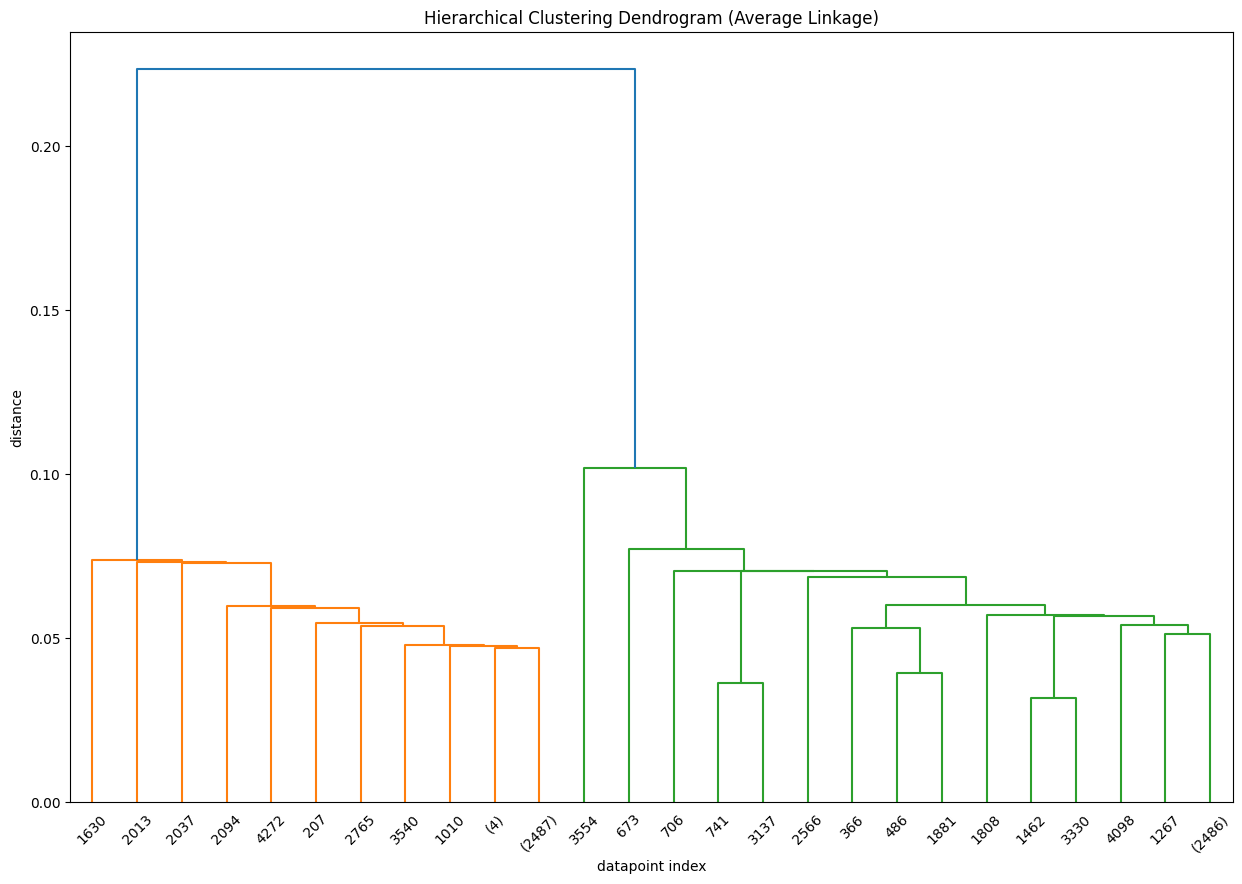

In [3]:
pairwise_distance_matrix = pdist(moons_dataset)
linkage_matrix_avg = sch.linkage(pairwise_distance_matrix, method='average')
linkage_matrix_single = sch.linkage(pairwise_distance_matrix, method='single')

plt.figure(figsize=(15, 10))
sch.dendrogram(linkage_matrix_single, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
plt.xlabel('datapoint index')
plt.ylabel('distance')
plt.show()

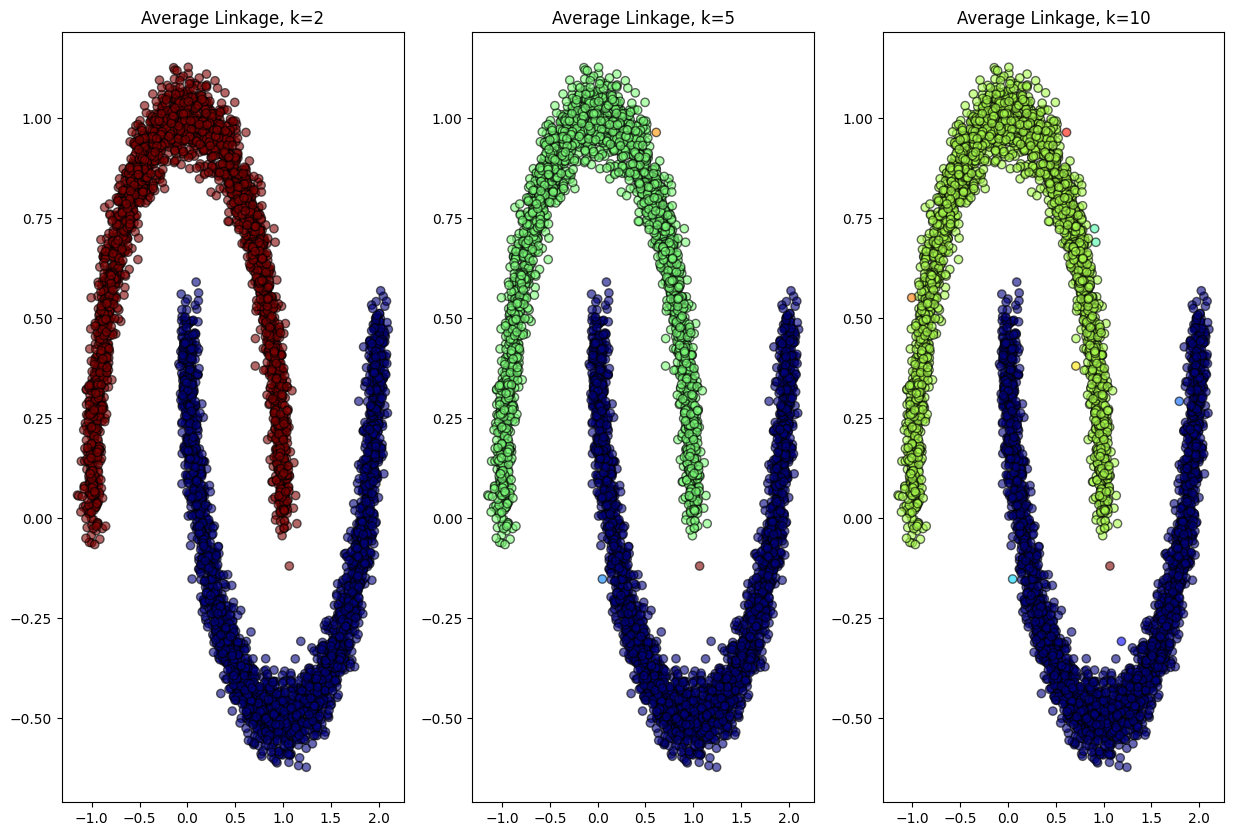

In [4]:
k_values = [2, 5, 10]

plt.figure(figsize=(15, 10))

for i, k in enumerate(k_values):
    plt.subplot(1, 3, i + 1)
    labels = fcluster(linkage_matrix_single, k, criterion='maxclust')
    plt.scatter(moons_dataset[:, 0], moons_dataset[:, 1], c=labels, cmap='jet', edgecolors='k', alpha=0.6)
    plt.title(f'Average Linkage, k={k}')

plt.show()

# Self Implementation

In [5]:
def calculate_pairwise_distance_matrix(ds):
    pairwise_distance_matrix_self = np.zeros((ds.shape[0], ds.shape[0]), dtype=np.float32)
    batch_size = 500
    squared_ds = np.sum(ds ** 2, axis=1, keepdims=True)
    for i in range(0, ds.shape[0], batch_size):
        end_i = min(i + batch_size, ds.shape[0])

        current_batch = ds[i:end_i]

        dot_prod = np.dot(current_batch, ds.T)

        dists = np.sqrt(squared_ds[i:end_i] + squared_ds.T - 2 * dot_prod)
        dists[dists < 1e-6] = 0

        pairwise_distance_matrix_self[i:end_i, :] = dists

    pairwise_distance_matrix_self = np.nan_to_num(pairwise_distance_matrix_self, 0)
    return pairwise_distance_matrix_self


def single_linkage(cluster_a, cluster_b, distance_matrix):
    min_distance = np.inf
    for i in cluster_a:
        for j in cluster_b:
            min_distance = min(min_distance, distance_matrix[i, j])
    return min_distance


def average_linkage(cluster_a, cluster_b, distance_matrix):
    total_dist = 0
    count = 0
    for i in cluster_a:
        for j in cluster_b:
            total_dist += distance_matrix[i, j]
            count += 1

    avg_dist = total_dist / count if count > 0 else 0
    return avg_dist


def hierarchical_clustering(pairwise_distance_matrix, k=1, linkage="single"):
    n = pairwise_distance_matrix.shape[0]
    clusters = {i: [i] for i in range(n)}
    cluster_history = []
    print("Before entering loop.")

    while len(clusters) > k:
        print("Inside loop.")
        print(len(clusters))
        min_distance = np.inf
        closest_pair = None

        cluster_keys = list(clusters.keys())

        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                c1, c2 = cluster_keys[i], cluster_keys[j]

                if linkage == "single":
                    distance = single_linkage(clusters[c1], clusters[c2], pairwise_distance_matrix)
                elif linkage == "average":
                    distance = average_linkage(clusters[c1], clusters[c2], pairwise_distance_matrix)
                else:
                    raise ValueError("Unknown linkage method. Only single linkage and average method supported.")
                
                if distance < min_distance:
                    min_distance = distance
                    closest_pair = (c1, c2)

        c1, c2 = closest_pair
        new_cluster = clusters[c1] + clusters[c2]
        del clusters[c1], clusters[c2]
        new_cluster_id = max(clusters.keys(), default=n) + 1
        clusters[new_cluster_id] = new_cluster
        cluster_history.append((c1, c2, min_distance, len(new_cluster)))


    return cluster_history


def plot_dendrogram(cluster_history):
    linkage_matrix = np.array(cluster_history)
    plt.figure(figsize=(15, 10))
    sch.dendrogram(linkage_matrix, labels=None)
    plt.title("Hierarchical clustering dendrogram")
    plt.xlabel("datapoints")
    plt.ylabel("distances")
    plt.show() 

In [9]:
pairwise_dist = calculate_pairwise_distance_matrix(moons_dataset)
print("Finished calculating pairwise distances.")
history = hierarchical_clustering(pairwise_dist)
plot_dendrogram(history)

/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_27877/1116960563.py:12: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(squared_ds[i:end_i] + squared_ds.T - 2 * dot_prod)


Finished calculating pairwise distances.
Before entering loop.
Inside loop.
5000
Inside loop.
4999
Inside loop.
4998
Inside loop.
4997
Inside loop.
4996
Inside loop.
4995
Inside loop.
4994
Inside loop.
4993
Inside loop.
4992
Inside loop.
4991
Inside loop.
4990
Inside loop.
4989
Inside loop.
4988
Inside loop.
4987
Inside loop.
4986
Inside loop.
4985
Inside loop.
4984
Inside loop.
4983
Inside loop.
4982
Inside loop.
4981
Inside loop.
4980
Inside loop.
4979
Inside loop.
4978
Inside loop.
4977
Inside loop.
4976
Inside loop.
4975
Inside loop.
4974
Inside loop.
4973
Inside loop.
4972
Inside loop.
4971
Inside loop.
4970
Inside loop.
4969
Inside loop.
4968
Inside loop.
4967
Inside loop.
4966
Inside loop.
4965
Inside loop.
4964
Inside loop.
4963
Inside loop.
4962
Inside loop.
4961
Inside loop.
4960
Inside loop.
4959
Inside loop.
4958
Inside loop.
4957
Inside loop.
4956
Inside loop.
4955
Inside loop.
4954
Inside loop.
4953
Inside loop.
4952
Inside loop.
4951
Inside loop.
4950
Inside loop.
4949
I

KeyboardInterrupt: 

In [20]:
def hierarchical_clustering_optimized(pairwise_dist_matrix, k=1, linkage="single"):
    n = pairwise_dist_matrix.shape[0]
    clusters = {i: [i] for i in range(n)}

    heap = []
    for i in range(n):
        for j in range(i+1, n):
            heapq.heappush(heap, (pairwise_dist_matrix[i, j], i, j))

    active_clusters = set(range(n))
    merge_history = []
    cluster_counter = n

    while len(active_clusters) > k:
        print("In loop")
        print(len(active_clusters))
        while True:
            dist, a, b = heapq.heappop(heap)
            if a in active_clusters and b in active_clusters:
                break
        
        new_cluster_id = cluster_counter
        new_cluster = clusters[a] + clusters[b]
        clusters[new_cluster_id] = new_cluster
        active_clusters.remove(a)
        active_clusters.remove(b)
        active_clusters.add(new_cluster_id)
        cluster_counter += 1

        merge_history.append((a, b, dist, len(clusters[new_cluster_id])))

        for c in active_clusters:
            if c == new_cluster_id:
                continue
            if linkage == "single":
                new_dist = min(pairwise_dist_matrix[i, j] for i in clusters[new_cluster_id] for j in clusters[c])
            elif linkage == "average":
                new_dist = np.mean([pairwise_dist_matrix[i, j] for i in clusters[new_cluster_id] for j in clusters[c]])
            
            heapq.heappush(heap, (new_dist, new_cluster_id, c))
    
    return merge_history, clusters


/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_27877/1116960563.py:12: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(squared_ds[i:end_i] + squared_ds.T - 2 * dot_prod)


Finished calculating pairwise distances.
In loop
5000
In loop
4999
In loop
4998
In loop
4997
In loop
4996
In loop
4995
In loop
4994
In loop
4993
In loop
4992
In loop
4991
In loop
4990
In loop
4989
In loop
4988
In loop
4987
In loop
4986
In loop
4985
In loop
4984
In loop
4983
In loop
4982
In loop
4981
In loop
4980
In loop
4979
In loop
4978
In loop
4977
In loop
4976
In loop
4975
In loop
4974
In loop
4973
In loop
4972
In loop
4971
In loop
4970
In loop
4969
In loop
4968
In loop
4967
In loop
4966
In loop
4965
In loop
4964
In loop
4963
In loop
4962
In loop
4961
In loop
4960
In loop
4959
In loop
4958
In loop
4957
In loop
4956
In loop
4955
In loop
4954
In loop
4953
In loop
4952
In loop
4951
In loop
4950
In loop
4949
In loop
4948
In loop
4947
In loop
4946
In loop
4945
In loop
4944
In loop
4943
In loop
4942
In loop
4941
In loop
4940
In loop
4939
In loop
4938
In loop
4937
In loop
4936
In loop
4935
In loop
4934
In loop
4933
In loop
4932
In loop
4931
In loop
4930
In loop
4929
In loop
4928
In loop
49

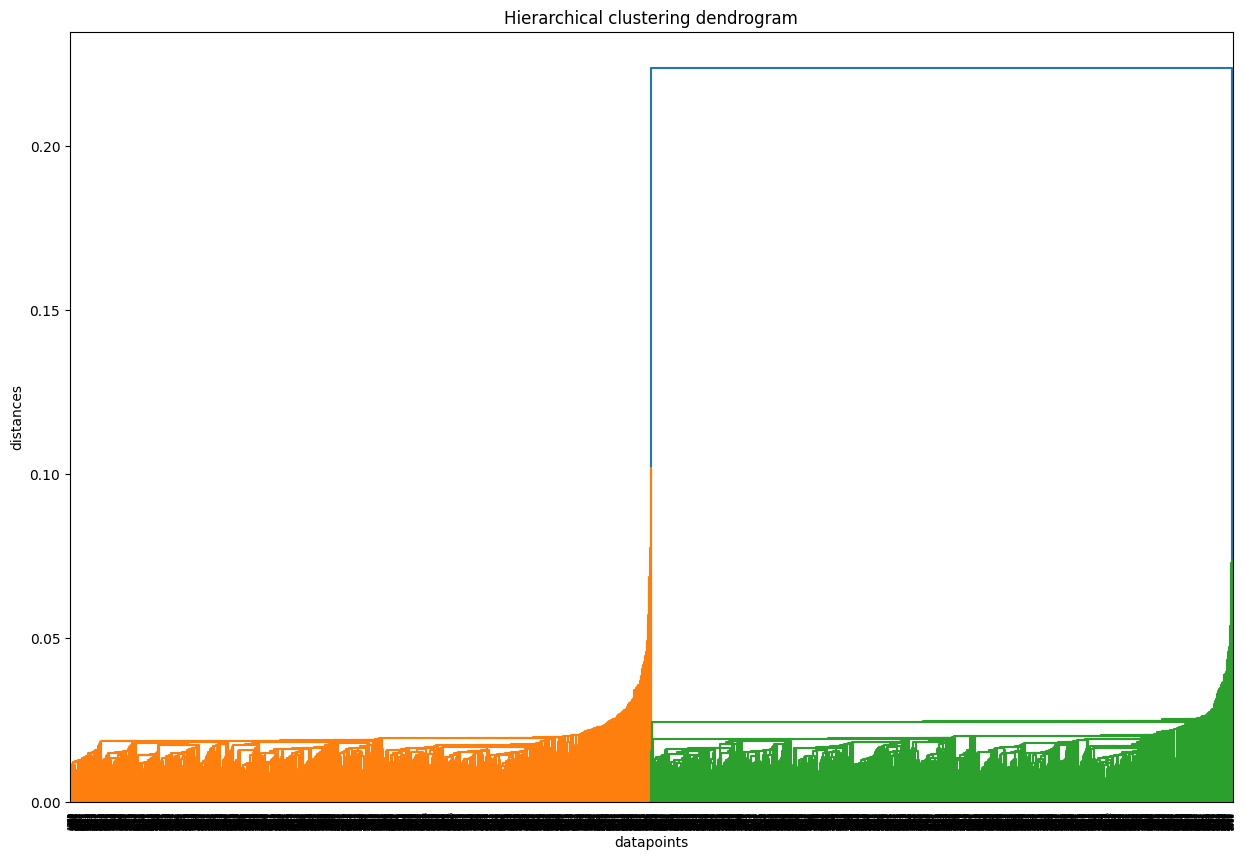

In [ ]:
pairwise_dist = calculate_pairwise_distance_matrix(moons_dataset)
print("Finished calculating pairwise distances.")
history, clusters = hierarchical_clustering_optimized(pairwise_dist )
plot_dendrogram(history)

In [16]:
def hierarchical_clustering_optimized_ultra_pro_max(pairwise_dist_matrix, k=1, linkage="single"):
    n = pairwise_dist_matrix.shape[0]
    clusters = {i: [i] for i in range(n)}

    cluster_dist = defaultdict(dict)
    heap = []
    for i in range(n):
        for j in range(i+1, n):
            cluster_dist[i][j] = cluster_dist[j][i] = pairwise_dist_matrix[i, j]
            heapq.heappush(heap, (pairwise_dist_matrix[i, j], i, j))

    active_clusters = set(range(n))
    merge_history = []
    cluster_counter = n

    while len(active_clusters) > k:
        print("In loop")
        print(len(active_clusters), "\n")
        while True:
            dist, a, b = heapq.heappop(heap)
            if a in active_clusters and b in active_clusters:
                break

        new_cluster_id = cluster_counter
        new_cluster = clusters[a] + clusters[b]
        clusters[new_cluster_id] = new_cluster
        active_clusters.remove(a)
        active_clusters.remove(b)
        active_clusters.add(new_cluster_id)
        cluster_counter += 1

        merge_history.append((a, b, dist, len(clusters[new_cluster_id])))

        for c in active_clusters:
            if c == new_cluster_id:
                continue
            
            if linkage == 'single':
                new_dist = min(cluster_dist[a].get(c, float('inf')), cluster_dist[b].get(c, float('inf')))
            elif linkage == 'average':
                total_points = len(clusters[new_cluster_id]) * len(clusters[c])
                new_dist = (sum(cluster_dist[a].get(c, 0) for _ in clusters[a]) +
                            sum(cluster_dist[b].get(c, 0) for _ in clusters[b])) / total_points
                
            cluster_dist[new_cluster_id][c] = cluster_dist[c][new_cluster_id] = new_dist
            heapq.heappush(heap, (new_dist, new_cluster_id, c))
        del clusters[a], clusters[b]

    return merge_history, clusters

/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_5554/1116960563.py:12: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(squared_ds[i:end_i] + squared_ds.T - 2 * dot_prod)


Finished calculating pairwise distances.
In loop
5000 

In loop
4999 

In loop
4998 

In loop
4997 

In loop
4996 

In loop
4995 

In loop
4994 

In loop
4993 

In loop
4992 

In loop
4991 

In loop
4990 

In loop
4989 

In loop
4988 

In loop
4987 

In loop
4986 

In loop
4985 

In loop
4984 

In loop
4983 

In loop
4982 

In loop
4981 

In loop
4980 

In loop
4979 

In loop
4978 

In loop
4977 

In loop
4976 

In loop
4975 

In loop
4974 

In loop
4973 

In loop
4972 

In loop
4971 

In loop
4970 

In loop
4969 

In loop
4968 

In loop
4967 

In loop
4966 

In loop
4965 

In loop
4964 

In loop
4963 

In loop
4962 

In loop
4961 

In loop
4960 

In loop
4959 

In loop
4958 

In loop
4957 

In loop
4956 

In loop
4955 

In loop
4954 

In loop
4953 

In loop
4952 

In loop
4951 

In loop
4950 

In loop
4949 

In loop
4948 

In loop
4947 

In loop
4946 

In loop
4945 

In loop
4944 

In loop
4943 

In loop
4942 

In loop
4941 

In loop
4940 

In loop
4939 

In loop
4938 

In loop
4937 


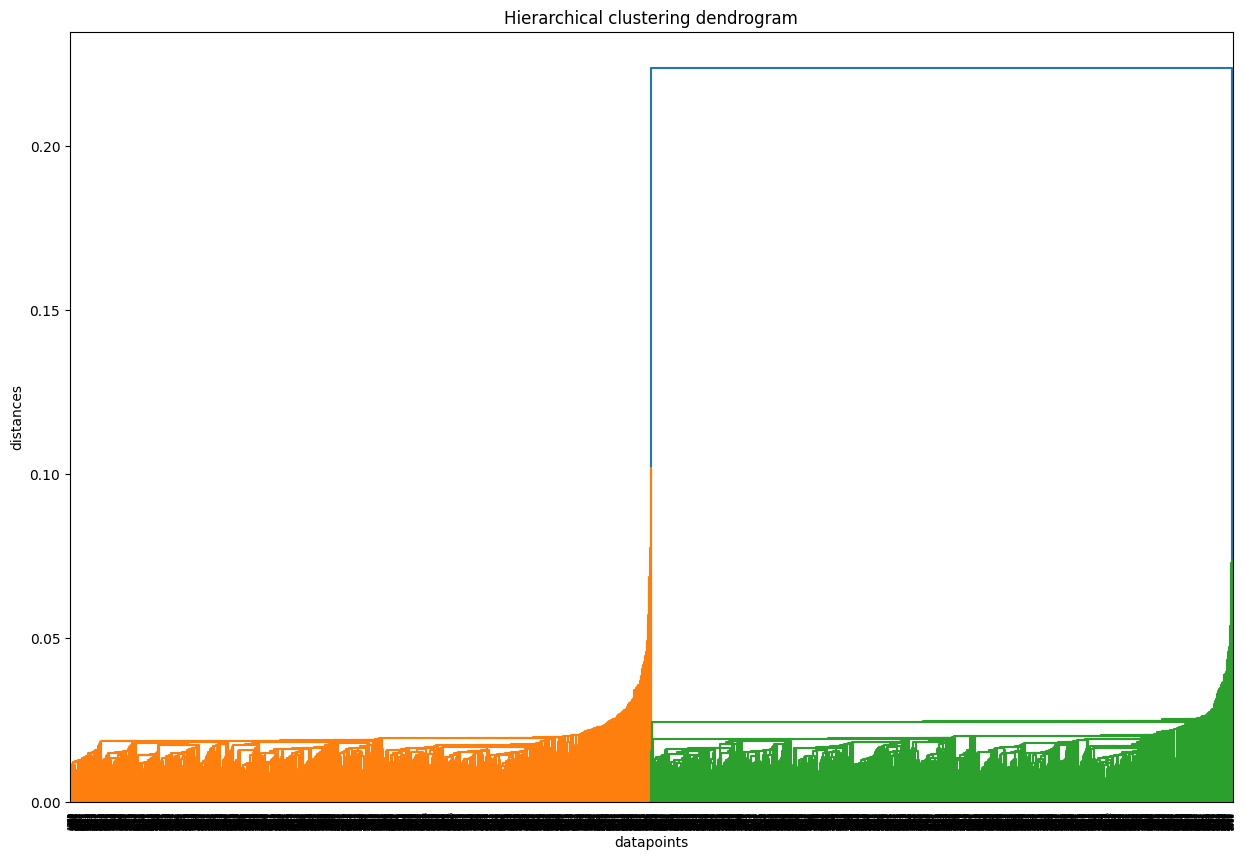

In [17]:
pairwise_dist = calculate_pairwise_distance_matrix(moons_dataset)
print("Finished calculating pairwise distances.")
history, clusters = hierarchical_clustering_optimized_ultra_pro_max(pairwise_dist)
plot_dendrogram(history)

In [35]:
def plot_clusters(clusters, data):
    plt.figure(figsize=(10, 7))
    
    colors = plt.cm.get_cmap("tab10", len(clusters))

    for cluster_id, point_indices in clusters.items():
        points = data[point_indices]
        plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster_id}", color=colors(cluster_id))

    plt.title("Hierarchical Clustering Scatter Plot")
    plt.legend()
    plt.show()

/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_5554/1059125894.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c = plt.cm.get_cmap("tab10")


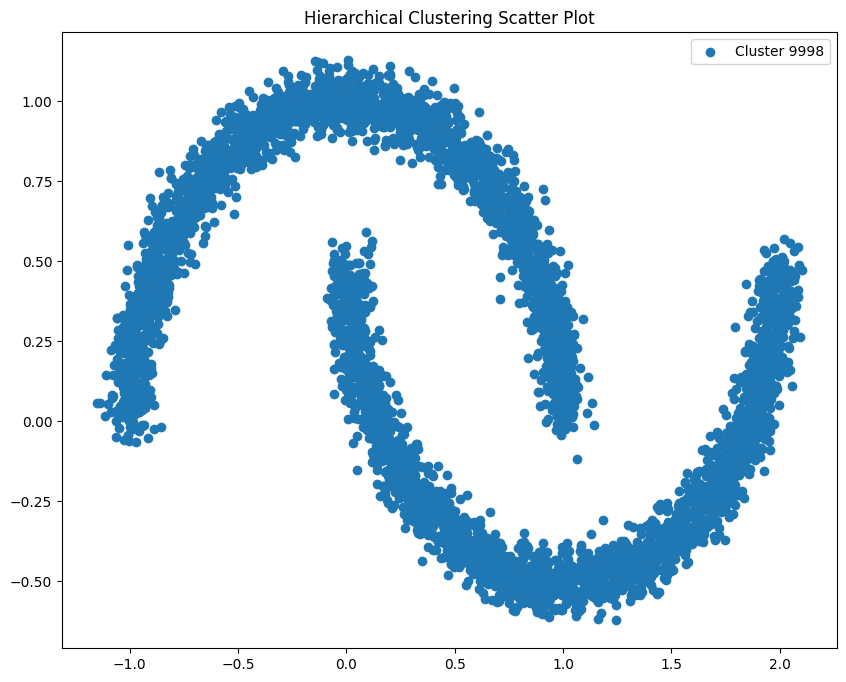

In [41]:
plot_scatter_map(clusters)

In [24]:
history_2, clusters_2 = hierarchical_clustering_optimized_ultra_pro_max(pairwise_dist, k=2, linkage="single")
# plot_dendrogram(history_2)

In loop
5000 

In loop
4999 

In loop
4998 

In loop
4997 

In loop
4996 

In loop
4995 

In loop
4994 

In loop
4993 

In loop
4992 

In loop
4991 

In loop
4990 

In loop
4989 

In loop
4988 

In loop
4987 

In loop
4986 

In loop
4985 

In loop
4984 

In loop
4983 

In loop
4982 

In loop
4981 

In loop
4980 

In loop
4979 

In loop
4978 

In loop
4977 

In loop
4976 

In loop
4975 

In loop
4974 

In loop
4973 

In loop
4972 

In loop
4971 

In loop
4970 

In loop
4969 

In loop
4968 

In loop
4967 

In loop
4966 

In loop
4965 

In loop
4964 

In loop
4963 

In loop
4962 

In loop
4961 

In loop
4960 

In loop
4959 

In loop
4958 

In loop
4957 

In loop
4956 

In loop
4955 

In loop
4954 

In loop
4953 

In loop
4952 

In loop
4951 

In loop
4950 

In loop
4949 

In loop
4948 

In loop
4947 

In loop
4946 

In loop
4945 

In loop
4944 

In loop
4943 

In loop
4942 

In loop
4941 

In loop
4940 

In loop
4939 

In loop
4938 

In loop
4937 

In loop
4936 

In loop
4935 

In loop
49

/var/folders/9d/hd3srjbx4rgbbrvnwxmcmh9c0000gn/T/ipykernel_5554/2324173138.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c = plt.cm.get_cmap("tab10", n)


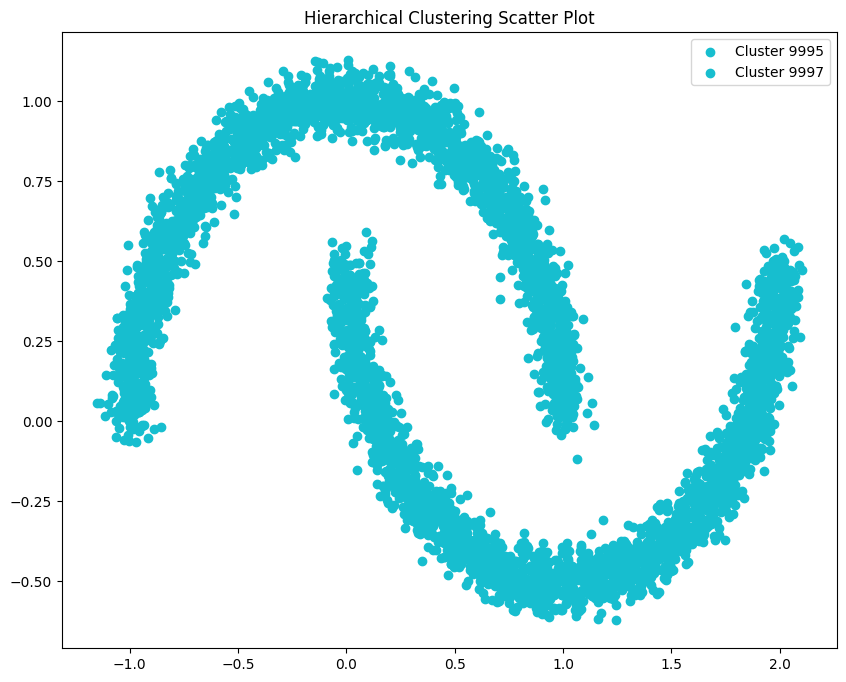

In [25]:
plot_scatter_map(clusters_2)